# Tutorial 03 - Chapter 4

Below you find exercises for Chapter 4. These exercises will prepare you in particular for the obligatory mid-term tests. The purpose of the prepared code snippets below is to give you some helpful structure for coding by predefining some useful variable names, but you do not need to use these prepared code snippets and prepared variable names if you do not want to. Do not hestitate to use the function `help()` to print the documentation of the functions that you need. If you are stuck, please ask one of the supervisors present.
<br>

Transform-based option pricing methods like the Laplace transform approach are useful tools to obtain option prices in many different more sophisticated models because often the characteristic function of the log-stock price is known in closed form, while its density is not. The fast Fourier transform is particularly useful because it can be employed to simultaneously compute the prices of options with multiple different strike prices. In this notebook we are applying these methods to the Heston model from Section 3.5. In the code snippet below, we define the variables $r$, $\gamma(0)$, $\kappa$ $\lambda$, $\widetilde \sigma$, $\rho$, $T$ and $S(0)$ for the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize.elementwise import find_root
from IPython.display import clear_output

r = 0.02
gam0 = 0.3**2
kappa = 0.3**2
lamb = 2.5
sig_tilde = 0.3
rho = -0.5
T = 1
S0 = 120

<br><br>

## Step 1: Computing option prices via the Laplace transform

Transform methods like the Laplace transform or the Fourier transform are a useful tool to compute the prices of options in models with known characteristic function. This is for example the case in the Heston model, in which no closed analytical formulas for computing option prices exist. In this notebook we will use the Heston model in its full form, i.e. without the simplifying assumption made in Section 3.5 of uncorrelated Brownian motions driving the stock and the stochastic volatility. Therefore, besides the parameters $\kappa$, $\lambda$ and $\widetilde\sigma$ there is an additional correlation parameter $\rho$ in the Heston model such that $d[W, \widetilde W](t) = \rho dt$.

The code snippet below contains a function `heston_char` with a stable implementation of the characteristic function $\chi_0(u) = \exp(\psi_0(0) + \psi_1(0) \log(S(0)) + \psi_2(0)\gamma(0))$ of $\log S(T)$ in the Heston model with parameters $\kappa$, $\lambda$, $\widetilde \sigma$ and $\rho$, initial variance $\gamma(0)$, initial stock price $S(0)$ and risk-free interest rate $r$ which is based on a paper by Albrecher, Mayer, Schoutens and Tistaert from 2007. Defining $B = \rho \widetilde{\sigma} u i - \lambda$, $D = \sqrt{B^2 + \widetilde\sigma^2 u (u + i)}$ and $G(t) = B \frac{e^{-D(T - t)} - 1}{2D} + \frac{e^{-D(T-t)} + 1}{2}$. this formula differs from the formula given in equation (4.8) in the lecture notes only in
\begin{align*}
\psi_0(t) &= i u r(T - t) - \frac{\kappa}{\widetilde \sigma^2} \big((B + D)(T - t) + 2 \log(G(t))\big) \\
\psi_2(t) &=  \frac{u(u + i) (e^{-D(T-t)} - 1)}{B (e^{-D(T - t)} - 1) + D(e^{-D (T - t)} + 1)}.
\end{align*}

In [2]:
def heston_char(u, S0, T, r, gam0, kappa, lamb, sig_tilde, rho):
    B = rho * sig_tilde * u * 1j - lamb
    D = np.sqrt(B**2 + sig_tilde**2 * u * (u + 1j))
    lnG = np.log(B * (np.exp(-D * T) - 1) / (2 * D) + (np.exp(-D * T) + 1) / 2)
    psi_0 = u * 1j * r * T - kappa / sig_tilde**2 * ((B + D) * T + 2 * lnG) 
    psi_1 = u * 1j
    psi_2 = u * (u + 1j) * (np.exp(-D * T) - 1) / (B * (np.exp(-D * T) - 1) + D * (np.exp(-D * T) + 1))
    return np.exp(psi_0 + psi_1 * np.log(S0) + psi_2 * gam0)

Our goal is now to use option pricing via the Laplace transform to compute call option prices in the Heston model for multiple different values of the strike $K$.

**Task 1.1**: Let $R$ be the constant from equation (4.4) in the lecture notes. Define a variable `R` containing an appropriate value for $R$ to price call options. Define an array `K_array` that contains 100 equally spaced values of the strike $K$ between 50 and 300.

*Useful Python commands*: `np.linspace`

## Important Note : If you take R = 1 then you will get negative call price which is not realistic 

In [3]:
R = 1.5 ##( we will try using R = 1.5)
K_array = np.linspace(50,300,100)

**Task 1.2**: Define a function `f_tilde(z, K)` that computes the Laplace transform of the call option payoff $(e^x - K)^+$ with strike `K`.

In [4]:
### see lecture note equation no. 4.6 

def f_tilde(z, K):
    result= ( K ** (1-z) ) / ( z * (z -1) )
    return result
    

We now want to measure the time that the Laplace pricing approach takes to compute the call option prices for the 100 different strikes. Therefore, we write the command `%%time` at the beginning of the code cell.

**Task 1.3**: Use a for-loop to compute the prices of European call options in the Heston model with parameters as above for the strikes $K$ taking values in `K_array`. In each iteration of the loop you should

- Use your functions `f_tilde` and `heston_char` to define the integrand from equation (4.4) as a Python function of the variable $u$.
- Use the scipy.integrate function `quad` to evaluate the integral (4.4). (The integral $\int_a^b f(u) du$ can be computed via the command `quad(f, a, b)[0]`). Choose the upper bound in the integral not too high to avoid numerical difficulties with the Heston characteristic function. 

Store the different prices in an array `call_Heston_Laplace`.

*Useful Python commands*: `np.real`, `np.exp`

### Note

How quad Works:
The quad function expects:

First argument: A function that takes one parameter (the integration variable)
Second/Third arguments: Integration bounds

In [5]:
%%time

call_Heston_Laplace = np.zeros(100)

def integrand ( u, K, R, S0, T, r, gam0, kappa, lamb, sig_tilde, rho):
    
    f_tilde_val = f_tilde( (R + ( 1j * u) ) , K)
    
    chi_val = heston_char( (u - (1j * R )) , S0, T, r, gam0, kappa, lamb, sig_tilde, rho)

    return np.real(f_tilde_val * chi_val)

for i, K in enumerate(K_array):
    
    def integrand_K(u):
        
        return integrand(u, K, R, S0, T, r, gam0, kappa, lamb, sig_tilde, rho)
    
    #value = np.real( f_tilde( (R + ( (np.sqrt(-1) ) * u) ) , K) * heston_char( (u - (np.sqrt(-1) ) * R ), S0, T, r, gam0, kappa, lamb, sig_tilde, rho) )
    integrand_result = quad ( integrand_K, 0 , 100)[0]
    
    call_Heston_Laplace[i] = ( np.exp(-r * T)/ np.pi ) * integrand_result

CPU times: user 352 ms, sys: 3.89 ms, total: 356 ms
Wall time: 357 ms


In [6]:
#last 5 values
call_Heston_Laplace[-5:]

array([1.23269291e-04, 1.04178967e-04, 8.81243315e-05, 7.46108501e-05,
       6.32263316e-05])

In [7]:
# First 10 values 

call_Heston_Laplace[:10]

array([71.00301045, 68.53468227, 66.06932727, 63.60792906, 61.15170066,
       58.70211312, 56.26092245, 53.83019372, 51.41232096, 49.0100417 ])

**Task 1.4**: Plot the option prices from the array `call_Heston_Laplace` against the strike prices from the array `K_array`.

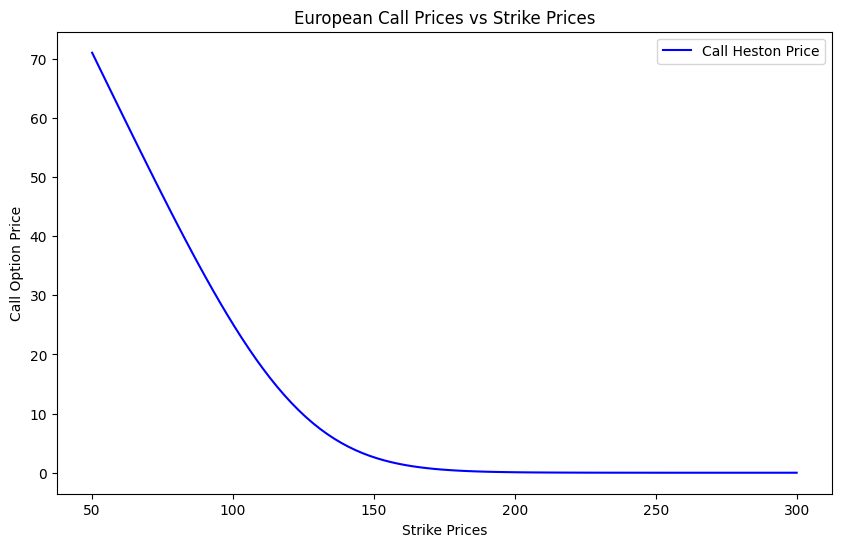

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_array, call_Heston_Laplace, label='Call Heston Price', color='blue')


plt.title('European Call Prices vs Strike Prices')
plt.xlabel('Strike Prices')
plt.ylabel('Call Option Price')
plt.legend()
plt.show()

## Part 1 all are correct

<br>

## Step 2: Computing option prices via the fast Fourier transform

Computing option prices via the fast Fourier transform as in Section 4.2 of the lecture notes has the advantage that this method is tailor-made for simultaneously calculating option prices with many different strikes, as we did in Step 1 with the Laplace transform. We would now like to see how much faster the fast Fourier transform performs this task.

**Task 2.1**: Write a function `g(u)` that computes the function $g$ from equation (4.13) in the lecture notes as a function of $u$ in the Heston model with parameters as before.

In [9]:
i=1j
def g(u):

    z = R + i * u

    f_tilde_0 = 1/ ( z * ( z -1) )
    
    #f_tilde_val = f_tilde( (R + ( i * u) ) , K)
    
    chi_val = heston_char( (u - (i * R )) , S0, T, r, gam0, kappa, lamb, sig_tilde, rho)
    
    result = f_tilde_0 * chi_val

    return result

In [10]:
#help(np.arange)

**Task 2.2**: Let $M = 5000$ and $N = 2^{15}$. Define an array `n` that contains the integers $1, 2, \dots, N$. Moreover, define an array `kappa_m` that contains the values $\kappa_m$ for $m \in \{1, \dots, N\}$ from equation (4.15) with $\kappa_1 := \log(30) =$ `np.log(K_array[0])`.

*Useful Python commands*: `np.arange`, `np.linspace`

In [11]:
M = 5000
N = 2 ** 15

n = np.arange(1, N + 1)

m = np.arange(1, N+1)

kappa_m = np.log(K_array[0]) + (m - 1) * (2 * np.pi / M)

# kappa_m = []

# for m in range(N):

#     k_m = np.log(K_array[0]) + (m-1) * ( (2 * np.pi)/M )
#     kappa_m.append(k_m)

In [12]:
kappa_m[-5:]

array([45.08322305, 45.08447969, 45.08573632, 45.08699296, 45.0882496 ])

**Task 2.3**: Define an array `x` that contains the values $x_n$ for $n \in \{1, \dots, N\}$ from equation (4.17). Afterwards, use the function `np.fft.fft` to compute the discrete Fourier transform $\widehat x_m$, $m \in \{1, \dots, N\}$ via the fast Fourier transform algorithm and store it in an array `x_hat`.

*Useful Python commands*: `np.exp`, `np.log`

In [13]:
x = np.zeros(N, dtype=complex)

delta = M/N

#i=1j

k1= np.log(K_array[0]) 

#x = q((n - 0.5) * Delta) * Delta * np.exp(-1j * (n - 1) * Delta * xi_1)

x = g((n - 0.5) * delta) * delta * np.exp(-1j * (n - 1) * delta * k1)

x



x_hat = np.fft.fft(x)

In [14]:
print(x[:10])
print (x_hat[:10])

[273.53650964+46.53368204j 251.78834233-16.48976071j
 209.57607435-51.47678973j 168.46003639-62.6058205j
 135.70664736-60.83961881j 111.14616161-53.62976136j
  92.81806895-44.74300333j  78.88345451-35.86764892j
  67.98362711-27.69288434j  59.18475979-20.45367803j]
[1751.51630537-220.80092981j 1751.66543158-222.35057861j
 1751.8124096 -223.9018592j  1751.95723275-225.45477051j
 1752.09989429-227.00931145j 1752.24038748-228.5654809j
 1752.37870559-230.12327772j 1752.51484183-231.68270078j
 1752.64878943-233.2437489j  1752.78054158-234.80642091j]


**Task 2.4**: Define an array `V_kappa_m` that contains the values $V_{\kappa_m}(0)$ from equation (4.18) for $m \in \{1, \dots, N\}$. Afterwards use the function `np.interp` to linearly interpolate the entries of the array `V_kappa_m` to obtain the call option prices corresponding to the strike prices $K$ from the array `K_array` from Task 1.1. Store them in an array `call_Heston_FFT`.

In [15]:
T

1

In [16]:
# taking t=0 and T = 1

V_kappa_m = ( np.exp( (-r) + (1-R) * kappa_m )/ (np.pi) ) * np.real(x_hat * np.exp(- 1j * 0.5 * delta * kappa_m) )


In [17]:
V_kappa_m

array([ 7.10030103e+01,  7.09415268e+01,  7.08799673e+01, ...,
       -8.14373917e-08, -8.13673151e-08, -8.12971519e-08], shape=(32768,))

In [19]:
K_log_array = np.log(K_array)

call_Heston_FFT = np.interp(K_log_array, kappa_m, V_kappa_m)

call_Heston_FFT

array([7.10030103e+01, 6.85346756e+01, 6.60693171e+01, 6.36079207e+01,
       6.11516900e+01, 5.87021066e+01, 5.62609121e+01, 5.38301895e+01,
       5.14123188e+01, 4.90100356e+01, 4.66264356e+01, 4.42649608e+01,
       4.19293987e+01, 3.96238321e+01, 3.73526801e+01, 3.51205904e+01,
       3.29324123e+01, 3.07931421e+01, 2.87078400e+01, 2.66815550e+01,
       2.47192372e+01, 2.28256444e+01, 2.10052523e+01, 1.92621570e+01,
       1.75999823e+01, 1.60218247e+01, 1.45301432e+01, 1.31267190e+01,
       1.18126137e+01, 1.05881438e+01, 9.45288165e+00, 8.40569558e+00,
       7.44466759e+00, 6.56727826e+00, 5.77040274e+00, 5.05039347e+00,
       4.40326083e+00, 3.82454989e+00, 3.30966935e+00, 2.85383725e+00,
       2.45228555e+00, 2.10018580e+00, 1.79289456e+00, 1.52589911e+00,
       1.29488089e+00, 1.09585205e+00, 9.25014968e-01, 7.78932532e-01,
       6.54453844e-01, 5.48721679e-01, 4.59206788e-01, 3.83615810e-01,
       3.19973127e-01, 2.66509992e-01, 2.21697590e-01, 1.84222622e-01,
      

In [20]:
# V_kappa_m = np.exp(-R * kappa_m) / np.pi * np.real(x_hat)

# # Interpolate V_kappa_m to get call prices at the strikes in K_array
# log_strikes = np.log(K_array)
# call_Heston_FFT = np.interp(log_strikes, kappa_m, V_kappa_m)


In [21]:
#call_Heston_FFT

In [22]:
len(K_log_array)

100

In [23]:
len(V_kappa_m)

32768

**Task 2.5**: Plot the option prices from the array `call_Heston_FFT` against the strike prices from the array `K_array`. If everything worked out, you should obtain the same output as in Task 1.4.

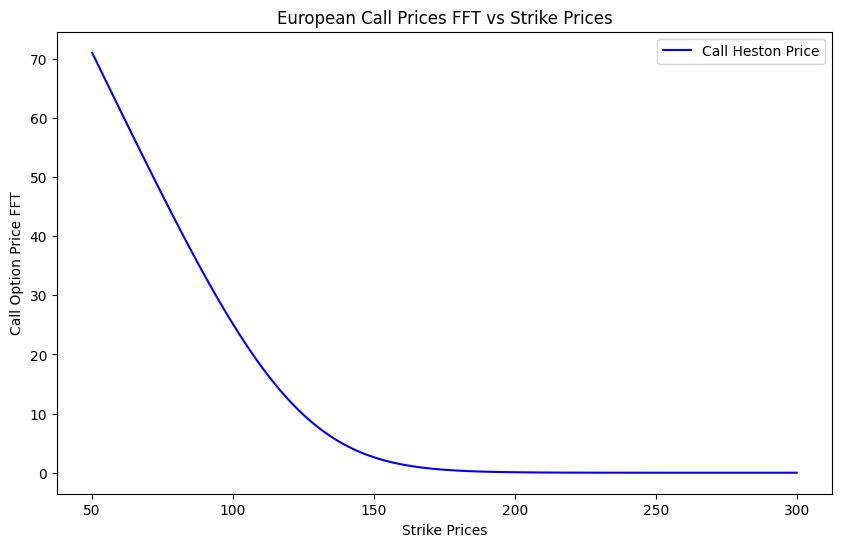

In [24]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_array, call_Heston_FFT, label='Call Heston Price', color='blue')


plt.title('European Call Prices FFT vs Strike Prices')
plt.xlabel('Strike Prices')
plt.ylabel('Call Option Price FFT')
plt.legend()
plt.show()

We still need to measure the time that the FFT method needs in comparison to the time that we obtained in Task 1.3 for the Laplace transform method.

**Task 2.6**: Write a function `european_Heston_FFT(S0, K, T, r, R, M, N, gam0, kappa, lamb, sig_tilde, rho)` that performs the whole option pricing via FFT algorithm from Tasks 2.1 to 2.4 for multiple strike prices given as an input array `K` to the function.

In [25]:
def european_Heston_FFT(S0, K, T, r, R, M, N, gam0, kappa, lamb, sig_tilde, rho):


    i=1j
    
    def g(u):
        
        z = R + i * u
        
        f_tilde_0 = 1/ ( z * ( z -1) ) #as kappa_1=0 so exponential terms will be 1
        
        #f_tilde_val = f_tilde( (R + ( i * u) ) , K)
        
        chi_val = heston_char( (u - (i * R )) , S0, T, r, gam0, kappa, lamb, sig_tilde, rho)
        
        result = f_tilde_0 * chi_val
        
        return result

    #M = 5000
    #N = 2 ** 15
    R = 1.5 ##( we will try using R = 1.5)
    #K_array = np.linspace(50,300,100)
    n = np.arange(1, N + 1)
    m = np.arange(1, N+1)
    kappa_m = np.log(K[0]) + (m - 1) * (2 * np.pi / M)
    #x = np.zeros(N, dtype=complex)
    delta = M/N
    k1= np.log(K[0]) 
    x = g((n - 0.5) * delta) * delta * np.exp(-1j * (n - 1) * delta * k1)
    x_hat = np.fft.fft(x)
    V_kappa_m = (np.exp( (-r) + (1-R) * kappa_m )/ (np.pi) ) * np.real(x_hat * np.exp(- 1j * 0.5 * delta * kappa_m) ) 
    K_log_array = np.log(K)
    call_Heston_FFT = np.interp(K_log_array, kappa_m, V_kappa_m)
    
    
    return  call_Heston_FFT

**Task 2.7**: Measure the time for an execution of the function `european_Heston_FFT` with strike prices given by the array `K_array` and all other input variables as before using the command `%%timeit -n 10 -r 3` and compare the execution time to the execution time for the Laplace transform pricing obtained in Task 1.3.

In [26]:
%%timeit -n 10 -r 3


check=european_Heston_FFT(S0, K_array, T, r, R, M, N, gam0, kappa, lamb, sig_tilde, rho)

#european_Heston_FFT = european_Heston_FFT(S0, K_array, T, r, R, M, N, gam0, kappa, lamb, sig_tilde, rho)


# Interpretation: ...

13.3 ms ± 406 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


### Interpretation :

The option price computational time for Laplace transformation is quite more than the fast furior transformation so the execution time for First Furior Transformation is very less  

## All outputs are correct

<br>

## Step 3: Computation of hedging strategies using the Laplace transform

Computing hedging strategies of options with arbitrary (non-path dependent) payoffs is easy using the Laplace transform (see Section 4.3 in the lecture notes). We'd now like to compute $\varphi_1(t)$ (i.e. the delta of an option) for an option with arbitrary payoff in the Heston model.

**Task 3.1**: Define a function `delta_Heston(u, S0, T, r, gam0, kappa, lamb, sig_tilde, rho)` that computes the derivative $\delta_0(u)$ of the Heston characteristic function $\chi_0(u)$ (given by the function `heston_char`) with respect to $S(0)$.

In [28]:
def delta_Heston(u, S0, T, r, gam0, kappa, lamb, sig_tilde, rho):

    chi0 = heston_char(u, S0, T, r, gam0, kappa, lamb, sig_tilde, rho)
    
    delta_0_u = chi0 * ( ( 1j * u) / S0 )
    
    return delta_0_u

**Task 3.2**: Use a for-loop and your function `delta_Heston` from Task 3.1 to compute the hedging strategy $\varphi_1(0)$ for the European call in the Heston model with $K$ taking values in the array `K_array` from Task 1.1. All other input variables should be as before. Store the result in an array `hedging_Heston_Laplace`.

*Useful Python commands*: `np.real`, `scipy.integrate.quad`, `np.exp`

In [29]:
### Use equation 4.9

hedging_Heston_Laplace = []

R = 1.5  # Laplace shift parameter

for K in K_array:
    def integrand(u):
        u_shifted = u - 1j * R
        
        delta = delta_Heston(u_shifted, S0, T, r, gam0, kappa, lamb, sig_tilde, rho)
        #factor = np.exp(-1j * u * np.log(K)) / (R - 1j * u)**2

        #factor = np.exp(-1j * u * np.log(K)) / (u)**2

        f_tilde_val = f_tilde((R + 1j * u), K)
        
        return np.real(delta * f_tilde_val)
    
    integral, _ = quad(integrand, 0, np.inf)
    
    #phi1_0 =  integral/ (2 * np.pi)
    
    phi1_0 =   ( np.exp(-r*T)/ (np.pi) ) *  integral

    
    hedging_Heston_Laplace.append(phi1_0)

hedging_Heston_Laplace = np.array(hedging_Heston_Laplace)


In [30]:
#hedging_Heston_Laplace = np.array ( hedging_Heston_Laplace )
hedging_Heston_Laplace

array([9.99165594e-01, 9.98733582e-01, 9.98124221e-01, 9.97282924e-01,
       9.96144086e-01, 9.94630346e-01, 9.92652123e-01, 9.90107533e-01,
       9.86882732e-01, 9.82852772e-01, 9.77883007e-01, 9.71831099e-01,
       9.64549643e-01, 9.55889388e-01, 9.45703041e-01, 9.33849577e-01,
       9.20198953e-01, 9.04637098e-01, 8.87071009e-01, 8.67433749e-01,
       8.45689134e-01, 8.21835857e-01, 7.95910816e-01, 7.67991406e-01,
       7.38196560e-01, 7.06686391e-01, 6.73660300e-01, 6.39353554e-01,
       6.04032348e-01, 5.67987531e-01, 5.31527200e-01, 4.94968494e-01,
       4.58628950e-01, 4.22817835e-01, 3.87827883e-01, 3.53927820e-01,
       3.21356033e-01, 2.90315654e-01, 2.60971222e-01, 2.33446992e-01,
       2.07826863e-01, 1.84155781e-01, 1.62442412e-01, 1.42662826e-01,
       1.24764895e-01, 1.08673109e-01, 9.42935431e-02, 8.15187082e-02,
       7.02321140e-02, 6.03123780e-02, 5.16367929e-02, 4.40843012e-02,
       3.75378710e-02, 3.18862957e-02, 2.70254676e-02, 2.28591869e-02,
      

**Task 3.3**: Plot the values of $\varphi_1(0)$ against the values of $K$ stored in the array `K_array` and interpret your result using a comment.

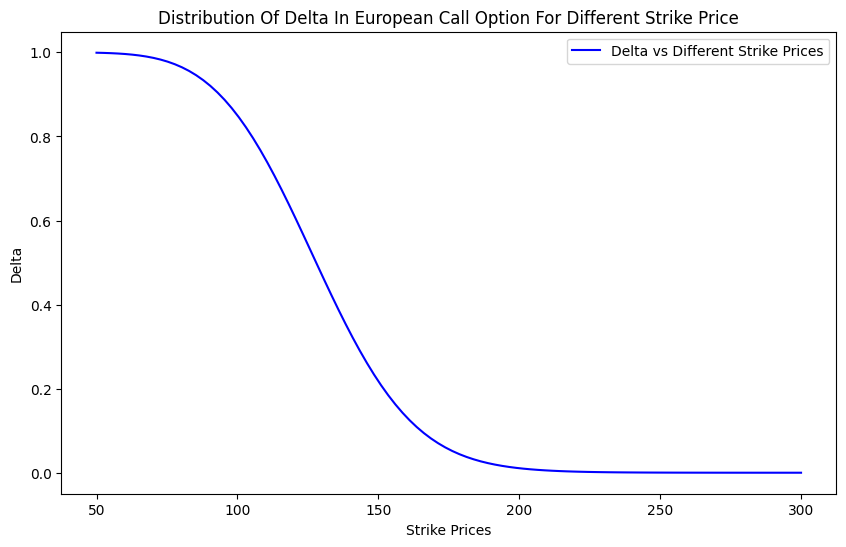

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_array, hedging_Heston_Laplace, label='Delta vs Different Strike Prices', color='blue')


plt.title('Distribution Of Delta In European Call Option For Different Strike Price')
plt.xlabel('Strike Prices')
plt.ylabel('Delta')
plt.legend()
plt.show()
# Interpretation: ...

## Interpretation : 


As usual for a European call option, the option delta starts at 1 for low values of the strike and decays in a sigmoid shape to 0 for large values of the strike. For low values of the strike, the instrinsic value of the call option much exceeds its continuation value so the price of the changes in the underlying induce almost perfectly equal changes in the option. If however the strike of the call option is large, the probability of the option terminating in the money becomes very small, so the option is worth almost nothing and its pricing curve flattens out, so the delta is almost equal to 0.

### Step 3 : All outputs are correct according to shared result

<br>

## Step 4: Calibration of the Heston model to S&P 500 call options using implied volatility

Calibration of an option pricing model, i.e. fitting the parameters of the model to real market data of options, is one of the most important tasks in computational finance. The following code snippet imports a dataset of European call options on the S&P 500 index on 06 September 2022 with expiry on 30 December 2022 (this corresponds to a time-to-maturity of approximately 0.3194 years). The dataset contains both the bid and ask price of the options, the midpoint between bid and ask price and the bid-ask spread for 320 different strikes. It also contains the underlying S&P 500 level on 06 September 2022 as well as the LIBOR rate as a proxy for the risk-free interest rate, which was interpolated to the time to maturity of the option.

In [32]:
options = pd.read_csv('data/options_SP500.csv')

The option dataset was imported as a pandas dataframe, which is sometimes handier than using a numpy array to work with data matrices.

**Task 4.1**: Use the `.head()` method of the pandas dataframe to print the first few lines of the dataframe `options`.

In [55]:
options.tail()

,Strike,Bid,Midpoint,Ask,Expiry,Spread,TTM,Underlying,Interest
315,5150.0,0.35,0.48,0.60,2022-12-30,0.25,0.319444,3908.189941,0.024678
316,5175.0,0.30,0.40,0.50,2022-12-30,0.20,0.319444,3908.189941,0.024678
317,5200.0,0.25,0.35,0.45,2022-12-30,0.20,0.319444,3908.189941,0.024678
318,5225.0,0.20,0.30,0.40,2022-12-30,0.20,0.319444,3908.189941,0.024678
319,5250.0,0.20,0.28,0.35,2022-12-30,0.15,0.319444,3908.189941,0.024678


**Task 4.2**: Define variables `sp500`, `ttm` and `libor` that contain the level of the S&P 500 at 06 September 2022, the time to maturity of the options in the dataset and the risk-free interest rate from the dataset, respectively. Then, define a numpy array `strikes` and a numpy array `prices` that contain the values of the `'Strike'` column and of the `'Midpoint'` column, respectively.

*Useful Python commands*: To cast a pandas dataframe or the column of a dataframe to a numpy array, use `.values` on the dataframe/the column.

In [56]:
# Assuming the dataset is already loaded in a DataFrame called df
# Let's inspect the first few rows (optional but useful)
# print(df.head())

# Extract the underlying index level, time to maturity, and LIBOR rate
sp500 = options['Underlying'][0]     # that is contain the level of the S&P 500 at 06 September 2022, which is the first value of the underlying
ttm = options['TTM'][0]           # Time to maturity
libor = options['Interest'][0]       # Risk-free interest rate

# Extract strike prices and midpoint prices as numpy arrays
strikes = options['Strike'].values
prices = options['Midpoint'].values


In [57]:
#strikes

In [58]:
ttm = options['TTM'][0]
ttm

np.float64(0.3194444444444444)

In [59]:
#sp500 = ...
#ttm = options['TTM'].values()
#ttm
#libor = ...


A possible way to calibrate the parameters of a stochastic model like the Heston model is to minimize the sum of squared errors between the model option prices $V_i(0)$ and the actual market-observed option prices $\pi_i$ as in equation (4.19) in the lecture notes. Often in practice, it is however preferred to calibrate model parameters to so-called ***implied volatilities*** instead of to the option prices:

The Black–Scholes formula establishes a one-to-one correspondence between the volatility $\sigma$ and the initial price $V(0)$ of a European call option if all other input variables are fixed. Instead of computing the call option price $V(0)$ from a given volatility $\sigma$, one can therefore also invert the order and compute the proper value of $\sigma$ from a given call option price $V(0)$. This is called the *implied volatility* of an option. Think of implied volatilities as just another way to quote option prices: In the same way as one can quote stock returns either as percentage returns or as logarithmic returns (with the possibility to convert each of the two to the other), one can quote option prices either using the actual price or using the implied volatility. 

Quoting option prices as implied volatilities has the advantage that it is a dimensionless way to view the value of an option: If e.g. from one day to another the value of a call option increases by 10 dollars, it is not ad hoc clear whether this change originates just from an increase in the underlying or if the option really got relatively more expensive compared to the underlying. If however the implied volatility of a call option increases from one day to another, one can immediately conclude that the option got relatively more expensive compared to the underlying, no matter whether the actual option price increased or decreased during that period of time.

In the following we will define a function that computes the implied volatility from an option price.

**Task 4.3**: Copy your function `european_BS(t, St, K, T, r, sigma, call)` that computes European option prices in the Black-Scholes model from Task 1.5 of the Week 03 notebook, or write it from scratch if you did not complete that task from week 03.

In [60]:
def european_BS(t, St, K, T, r, sigma, call):
    d1=(np.log(St/K) + r*(T-t) + ((sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t))
    d2=(np.log(St/K) + r*(T-t) - ((sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t))
    if call ==1:
        vt_call= (St*(norm.cdf(d1)))-(K*(np.exp(-r*(T-t)))*(norm.cdf(d2)))
        return vt_call
    elif call==0:
        vt_put= (K*(np.exp(-r*(T-t)))*(norm.cdf(-d2))) - (St*(norm.cdf(-d1)))
        return vt_put

The following code snippet contains a function `ImpVol(V0, S0, r, T, K)` that returns the implied volatility corresponding to an option price `V0` with underlying `S0`, risk-free interest rate `r`, time to maturity `T` and strike `K`. The function uses Chandrupatla’s bracketing algorithm from the `scipy.optimize.elementwise` function `find_root` to find the implied volatility. The advantage of this function is that you can supply a whole numpy array for the input arguments `V0` and `K` to simultaneously compute the implied volatility for multiple options with different strike prices. If the input argument `call` is set to 1, the function assumes that the prices in `V0` are call option prices, if it is set to 0, the function assumes that they are put option prices.

In [61]:
def ImpVol(V0, S0, r, T, K, call):
    def objective(sigma, K, V0):
        return european_BS(0, S0, K, T, r, sigma, call=call) - V0
    lower = np.repeat(1e-12, np.size(K))
    upper = np.repeat(5, np.size(K))
    return find_root(objective, (lower, upper), args=(K, V0)).x

**Task 4.4**: Use the above function `ImpVol` to compute the implied volatilities of the market-quoted S&P 500 call option prices from the array `prices` and store them in an array `impvols`. Afterwards, plot the implied volatilites against the strike prices from the array `strikes`. Interpret your result using a comment. Why is the Black-Scholes model not suitable to model this data set of S&P 500 options?

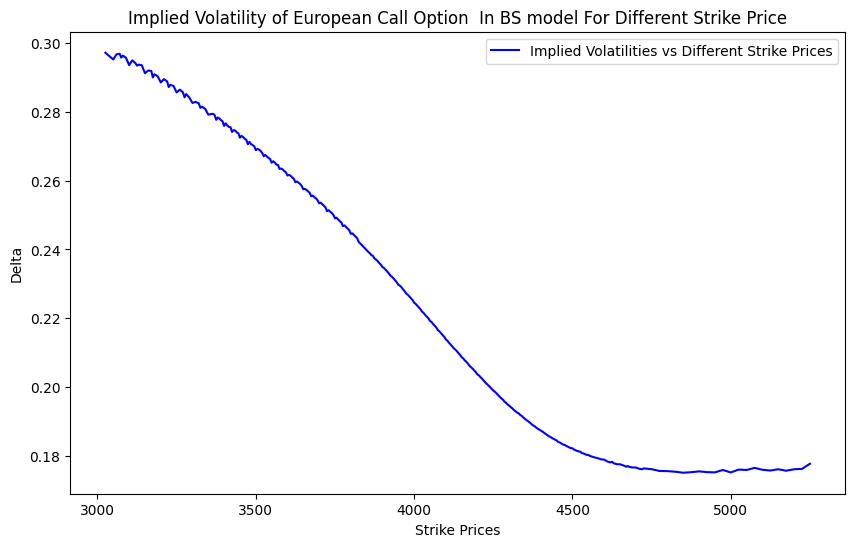

In [62]:
impvols = []

impvols = ImpVol(prices,sp500,libor,ttm,strikes,call=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strikes, impvols, label='Implied Volatilities vs Different Strike Prices', color='blue')


plt.title('Implied Volatility of European Call Option  In BS model For Different Strike Price')
plt.xlabel('Strike Prices')
plt.ylabel('Delta')
plt.legend()
plt.show()
# Interpretation: ...


#...
#plt.show()

# Interpretation: ...

In [63]:
#impvols

Due to the advantages of using implied volatility as a dimensionless way to quote option prices, it is generally also preferrable calibrate model parameters to implied volatilites by minimizing the sum of squared implied volatility errors $\sum_{i=1}^n \big[\mathrm{IV}(\pi_i) - \mathrm{IV}(V_i(0))\big]^2$, where $\mathrm{IV}(\pi_i)$ denotes the implied volatility of the market-observed options and $\mathrm{IV}(V_i(0))$ denotes the implied volatility of the options in the stochastic model. We first need a function that computes the latter in the Heston model.

**Task 4.5**: Write a function `ImpVol_Heston(S0, K, T, r, R, gam0, kappa, lamb, sig_tilde, rho)` that accepts an array `K` of strike prices as an input and then first computes the array of corresponding European call option prices in the Heston model using the function `european_Heston_FFT` from Task 2.6 with $M = 5000$ and $N = 2^{15}$. Afterwards, it should return the implied volatility corresponding to these Heston call option prices by using the function `ImpVol` from above.

In [ ]:
def ImpVol_Heston(S0, K, T, r, R, gam0, kappa, lamb, sig_tilde, rho):
    ...
    return ...

**Task 4.6**: Write a function `min_func(params)` that is supposed to be passed to the scipy `minimize` routine (see the code cell one further below). The function should accept an array `params` as an argument that contain the parameters $\gamma(0), \kappa, \lambda, \widetilde \sigma$ and $\rho$ in this order. It should then compute the Heston model implied volatilities corresponding to these parameters and to the options with strike prices given by the array `strikes` from the dataset using the function `ImpVol_Heston` with $R = 1.5$. Finally it should return the mean squared error $\frac{1}{n}\sum_{i=1}^n \big[\mathrm{IV}(\pi_i) - \mathrm{IV}(V_i(0))\big]^2$ between the Heston model implied volatilities and the market implied volatilities from the array `impvols`.

*Remark*: The given code at the end of the function will print a callback during the minimization process in the next task. You can leave it as it is.

In [ ]:
def min_func(params):
    gam0, kappa, lamb, sig_tilde, rho = params
    ...
    mse = ...

    ### Callback section
    global it
    clear_output(wait=True)
    print('It: {:4d},  '.format(it) + ''.join([name + ' = {:.4e}, '.format(param) for name, param in zip(['gamma_0', 'kappa', 'lambda', 'sigma_tilde', 'rho'], params)]) + 'MSE = {:.6e}'.format(mse))
    it += 1
    ###
    return mse

The code snippet below now performs the minimization of the implied volatility mean squared error using the scipy.optimize routine `minimize`. A very solid first choice for a minimization algorithm is often the Nelder-Mead algorithm, so we also use it below. The minimization uses the initial parameter guess $\gamma(0) = \kappa = 0.05$, $\lambda = 0.5$, $\widetilde \sigma = 0.3$, $\rho = -0.5$. and also specifies bounds for the five parameters.

*Remark*: Calibration of parameters in the Heston model to options with a single maturity is very sensitive to the chosen initial guess of parameters. Different initial guesses may lead to different fitted parameters because the scipy minimize routine might get stuck in a suboptimal local minimum.

In [ ]:
it = 1
initial_params = np.array([0.05, 0.05, 0.5, 0.3, -0.5])
bounds = [[1e-15, 2], [1e-15, 2], [1e-15, 10], [1e-15, 1], [-0.999, 0.999]]
fitted_params = minimize(min_func, initial_params, bounds=bounds, method='Nelder-Mead').x

**Task 4.7**: Use the function `ImpVol_Heston` from Task 4.5 to compute both the Heston model implied volatilies corresponding to the initial parameter guess (from the array `initial_params`) and to the fitted parameters (from the array `fitted_params`). Store these in arrays `impvol_model_init` and `impvol_model_fitted`, respectively. Afterwards, use the function `european_Heston_FFT` to compute both the heston model prices corresponding to the initial parameter guess and to the fitted parameters and store them in arrays `prices_model_init` and `prices_model_fitted`, respectively.

In [ ]:
impvol_model_init = ...
impvol_model_fitted = ...
prices_model_init = ...
prices_model_fitted = ...

**Task 4.8**: Plot the marked-observed implied volatilites (from the array `impvols`), the initial guess implied volatilities (from the array `impvol_model_init`) and the fitted model implied volatilities (from the array `impvol_model_fitted`) in a common plot. Repeat this for the prices instead of implied volatilities in a separate plot window. Interpret your result using a comment. What are the advantages of fitting parameters to implied volatilities instead of prices?

In [ ]:
...
plt.show()

# Interpretation: ...